### Mapping NYC population change from 2000 to 2010

In [1]:
# import packages
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import matplotlib as plt
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#bash commands run to move shapefile for reproducability
#!mv 'nyct2010_17c.zip' $PUIDATA
#unzip folder into 'Census' folder in PUIDATA
#!unzip nyct2010_17c.zip -d Census

In [3]:
#shapefile for census tracts
censusdf = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Census/nyct2010_17c/nyct2010.shp")
censusdf.head(3)

,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016794,2.497010e+06,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199811,1.906016e+06,"POLYGON ((994133.507019043 214848.8975830078, ..."
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168737,1.860938e+06,"POLYGON ((993108.3057861328 216013.1307983398,..."


In [4]:
#checking shape of df
censusdf.shape

(2166, 12)

In [5]:
DFDATA = os.getenv('DFDATA')
df = pd.read_csv(DFDATA + '/37cg-gxjd/1414245769/37cg-gxjd')
df.head(3)

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population
0,Bronx,2000,5,2,100,12780
1,Bronx,2000,5,2,200,3545
2,Bronx,2000,5,2,400,3314


In [6]:
#munging data for preparation to merge with censusdf

df = df.rename(columns={'DCP Borough Code':'BoroCode'})
df['BoroCode'] = df['BoroCode'].astype(str)
df['Census Tract'] = df['Census Tract'].astype(str)

stringfill = lambda x:x.zfill(6)
df['Census Tract'] = df['Census Tract'].apply(stringfill)
df['BoroCT2010']=df['BoroCode']+df['Census Tract']

df.head(3)

,Borough,Year,FIPS County Code,BoroCode,Census Tract,Population,BoroCT2010
0,Bronx,2000,5,2,000100,12780,2000100
1,Bronx,2000,5,2,000200,3545,2000200
2,Bronx,2000,5,2,000400,3314,2000400


In [7]:
#obtaining df for population in 2000
df2000 = df[df['Year']==2000]
df2000.drop(['Borough','BoroCode','Census Tract','Year','FIPS County Code'], axis=1, inplace=True)
df2000.head(3)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Population,BoroCT2010
0,12780,2000100
1,3545,2000200
2,3314,2000400


In [8]:
#obtaining df for population in 2010
df2010 = df[df['Year']==2010]
df2010.drop(['Borough','BoroCode','Census Tract','Year','FIPS County Code'], axis=1, inplace=True)
df2010.head(3)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Population,BoroCT2010
2168,11091,2000100
2169,4334,2000200
2170,5503,2000400


In [9]:
df2010.shape

(2168, 2)

In [10]:
#merging the population count dfs
df_ = pd.merge(df2000, df2010, how='inner', on='BoroCT2010',).rename(columns={'Population_x':'2000pop',
                                                                              'Population_y':'2010pop'})

#calculate population percent change
df_['popChange'] = (df_['2010pop']-df_['2000pop'])/df_['2000pop']
df_.drop(['2000pop','2010pop'], axis=1, inplace=True)

#cleaning data, replacing na and inf(from dividing by 0) values with 0
df_.replace([np.inf, -np.inf], np.nan, inplace=True)
df_.fillna(0, axis=1, inplace=True)

df_.head(3)

,BoroCT2010,popChange
0,2000100,-0.132160
1,2000200,0.222567
2,2000400,0.660531


In [11]:
df_.describe()

,popChange
count,2168.000000
mean,0.155601
std,2.805067
min,-1.000000
25%,-0.049839
50%,0.000762
75%,0.067511
max,106.285714


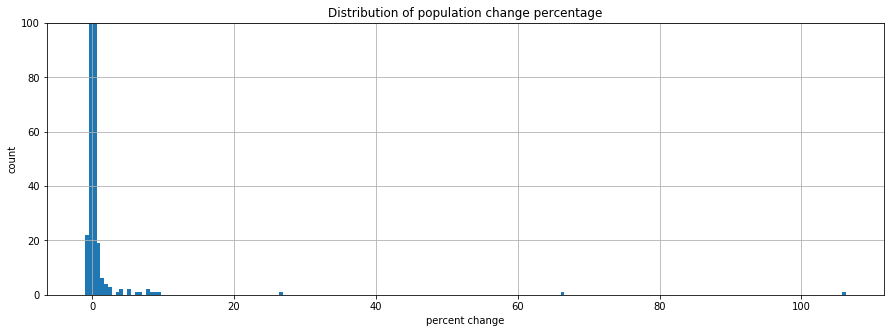

In [12]:
#visualizing distribution of data to find outliers
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
df_.hist(ax=ax, bins=200)
pl.ylim(0,100)
pl.title('Distribution of population change percentage')
pl.xlabel('percent change')
pl.ylabel('count');

#### Figure 1 shows the distribution of population change percentages for the NYC census tract data. The vast majority are are near zero (as expected), but there are a few far outliers due to very small population counts in the census data.

In [13]:
#changing far outliers (above 100% change to 0), maybe not the best approach but the simplest...
df_[df_['popChange'] > 1] = 0

In [14]:
df_.describe()

,popChange
count,2168.000000
mean,0.015069
std,0.162579
min,-1.000000
25%,-0.049839
50%,0.000000
75%,0.061071
max,0.915519


In [15]:
mapdf = pd.merge(censusdf,df_,how='left',on='BoroCT2010')
mapdf.fillna(0, axis=1, inplace=True) #filling minor discrepancies between the two dfs
mapdf.head(3)

,CTLabel,BoroCode,BoroName,CT2010,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry,popChange
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016794,2.497010e+06,"POLYGON ((962269.1260375977 173705.5001831055,...",0.001422
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199811,1.906016e+06,"POLYGON ((994133.507019043 214848.8975830078, ...",0.035381
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168737,1.860938e+06,"POLYGON ((993108.3057861328 216013.1307983398,...",0.093304


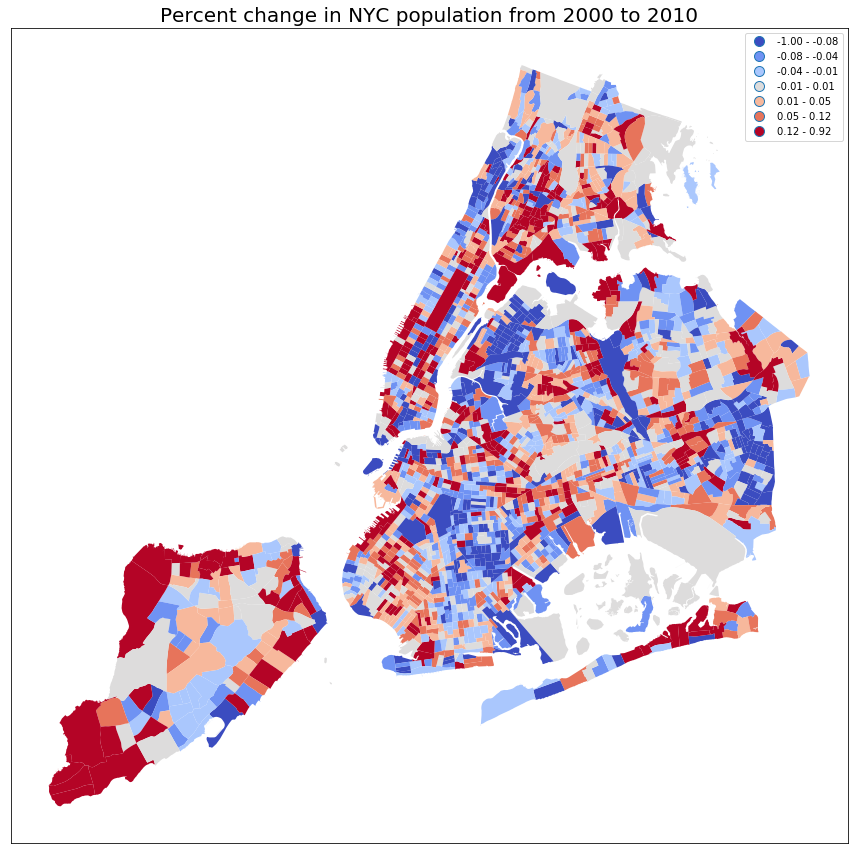

In [16]:
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)
mapdf.plot(ax=ax, column='popChange',cmap='coolwarm',scheme='quantiles',k=7,legend=True)
pl.title('Percent change in NYC population from 2000 to 2010', fontsize=20);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#### Figure 2 maps the percentage in population change for each NYC census tract from 2000-2010. Blue indicates a population decrease while red indicates an increase. There are some oddities in the map due to the original census data...we wouldn't expect any population in park areas like Central Park, Greenwood Cemetery, etc. but the data is there in the census ([NYTimes article about it here](http://www.nytimes.com/2011/03/26/nyregion/26census.html)). These very small counts result in large percentage changes that affect the map. A next step could be to identify the designated park/open areas and color them separately.